# Implementacion de un MSA 

## Implementacion de un DPP mediante una FPGA

El sistema implementado se encuentra todo embebido en tres IP Cores diseñados para PYNQ

### Carga de librerias

Aqui se cargan las librerias

In [1]:
from pynq import PL
from pynq import Overlay
from pynq import allocate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Carga del Overlay

Aqui se carga el overlay de la FPGA para el MSA

In [28]:
PL.reset()
xadc_stream = Overlay('counter_2.bit')

In [14]:
xadc_stream?

### Creacion de objetos

Creacion de los objetos del Overlay para comunicarse con los diferentes perifericos que cuentan con AXI4

In [36]:
dma      = xadc_stream.axi_dma_0
dma_dpp  = xadc_stream.axi_dma_1
xdpp     = xadc_stream.AXI_DPP_Prepross_0

### Configuracion del DPP

Se crearan las funciones para escribir en los registros de configuracion

In [38]:
# definicion de funciones de reset y clear
def set_xadc(self):
    old = self.read(0x00)
    self.write(0x00, old | 0x01)

def cls_xadc(self):
    old = self.read(0x00)
    self.write(0x00, old & 0xFE)

def set_fir(self):
    old = self.read(0x00)
    self.write(0x00, old | 0x02)

def cls_fir(self):
    old = self.read(0x00)
    self.write(0x00, old & 0xFD)

def set_trapz(self):
    old = self.read(0x00)
    self.write(0x00, old | 0x04)

def cls_trapz(self):
    old = self.read(0x00)
    self.write(0x00, old & 0xFB)

def set_count(self):
    old = self.read(0x00)
    self.write(0x00, old | 0x08)

def cls_count(self):
    old = self.read(0x00)
    self.write(0x00, old & 0xF7)

def set_dppram(self):
    old = self.read(0x00)
    self.write(0x00, old | 0x10)

def cls_dppram(self):
    old = self.read(0x00)
    self.write(0x00, old & 0xEF)

# definicion de funciones de mux
def mux_dpp(self, mux):
    self.write(0x04, mux)

# definicion de funciones de slice de trapz
def slice_trapz_dpp(self, sli):
    self.write(0x08, sli)

# definicion de funcion de comparador de trigger
def comp_trg_dpp(self, comp_trg):
    self.write(0x0C, comp_trg)

# definicion de funcion de comparador de nivel
def comp_lvl_dpp(self, comp_lvl):
    self.write(0x10, comp_lvl)

# registros de lectura
def read_count_dpp(self):
    return self.read(0x14)

def read_amp_dpp(self):
    return self.read(0x18) 

## Configuracion del DPP Preprocesamiento

Aqui se configuraran los niveles de comparacion
- Comparacion de trigger
- Comparacion de nivel

Tambien se resetean todos los contadores y se setean de nuevo para funcionamiento

In [254]:
# Ajuste de los niveles de comparacion
comp_trg_dpp(xdpp, 2000)  # nivel de comparacion del trigger
comp_lvl_dpp(xdpp, 55000) # nivel de captura de eventos
slice_trapz_dpp(xdpp, 6)  # Slice en el dato de entrada

# reset de todos los perifericos
cls_xadc(xdpp)
cls_fir(xdpp)
cls_trapz(xdpp)
cls_count(xdpp)
cls_dppram(xdpp)

# set de todos los perifericos
set_xadc(xdpp)
set_fir(xdpp)
set_trapz(xdpp)
set_count(xdpp)
set_dppram(xdpp)

### Impresion de la señal original

Aqui se captura y se imprime la señal original

In [74]:
mux_dpp(xdpp, 0)          # selector de Mux

buff_deep = 8300
dpp_deep  = 2300

input_buffer = allocate(shape=(buff_deep,), dtype=np.uint32)
input_bufdpp = allocate(shape=(dpp_deep,), dtype=np.uint32)

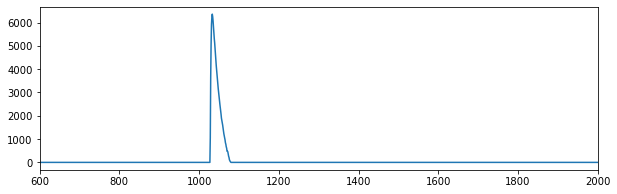

Suma de histograma =  135139


In [232]:
mux_dpp(xdpp, 0)
dma.recvchannel.transfer(input_buffer)
input_buffer1 = input_buffer
for i in range(len(input_buffer1)):
    if input_buffer1[i]>0.5:
        input_buffer1[i] = input_buffer1[i]-1

plt.figure(figsize=(10,3))
#plt.bar(range(0, 8300), input_buffer1)#, edgecolor='black')
plt.plot(range(0, buff_deep), input_buffer1)
plt.xlim(600, 2000)
plt.show()

#print("Numero de conteos = ", xgpio.read(8))
print("Suma de histograma = ", np.sum(input_buffer))

In [78]:
# Convierte el array de NumPy a un DataFrame de Pandas
df = pd.DataFrame(input_buffer)

# Guarda el DataFrame como un archivo CSV
df.to_csv('raw_signal.csv', index=False)

### Impresion de la señal filtrada con filtro FIR

Aqui se captura y se imprime la señal filtrada con el filtro FIR

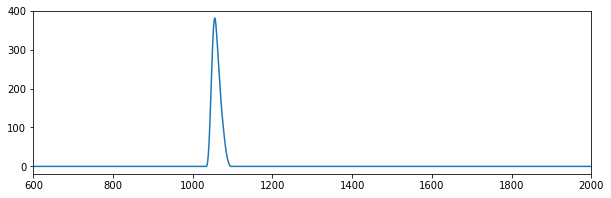

Suma de histograma =  9530


In [234]:
mux_dpp(xdpp, 1)
dma.recvchannel.transfer(input_buffer)
input_buffer1 = input_buffer
for i in range(len(input_buffer1)):
    if input_buffer1[i]>0.5:
        input_buffer1[i] = input_buffer1[i]-1

plt.figure(figsize=(10,3))
#plt.bar(range(0, 8300), input_buffer1)#, edgecolor='black')
plt.plot(range(0, buff_deep), input_buffer1)
plt.xlim(600, 2000)
plt.show()

#print("Numero de conteos = ", xgpio.read(8))
print("Suma de histograma = ", np.sum(input_buffer))

In [28]:
# Convierte el array de NumPy a un DataFrame de Pandas
df = pd.DataFrame(input_buffer)

# Guarda el DataFrame como un archivo CSV
df.to_csv('fir_signal.csv', index=False)

### Impresion de la señal de filtro Trapezoidal

Aqui se captura y se imprime la señal de filtro trapezoidal

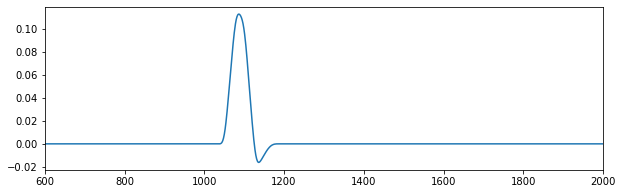

Suma de histograma =  4118092


In [236]:
mux_dpp(xdpp, 2)
slice_trapz_dpp(xdpp, 6)
dma.recvchannel.transfer(input_buffer)
input_buffer1 = input_buffer/2**16
for i in range(len(input_buffer1)):
    if input_buffer1[i]>0.5:
        input_buffer1[i] = input_buffer1[i]-1

plt.figure(figsize=(10,3))
#plt.bar(range(0, 8300), input_buffer1)#, edgecolor='black')
plt.plot(range(0, buff_deep), input_buffer1)
plt.xlim(600, 2000)
plt.show()

#print("Numero de conteos = ", xgpio.read(8))
print("Suma de histograma = ", np.sum(input_buffer))

In [36]:
# Convierte el array de NumPy a un DataFrame de Pandas
df = pd.DataFrame(input_buffer)

# Guarda el DataFrame como un archivo CSV
df.to_csv('trapz_signal.csv', index=False)

### Pregunta por el numero de conteos detectados

Aqui se solicita el valor de conteos detectados por el sistema FPGA

In [188]:
print("Numero de conteos = ", read_count_dpp(xdpp))

Numero de conteos =  1835


### Creacion de histograma de energias

Aqui se solicitan los datos discriminados de las energias y la impresion del histograma

In [190]:
print("Nivel de altura = ", read_amp_dpp(xdpp))

Nivel de altura =  9910


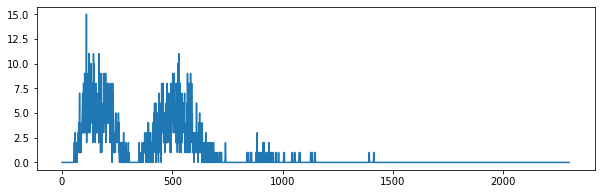

Numero de conteos =  1978
Suma de histograma =  1979


In [255]:
dma_dpp.recvchannel.transfer(input_bufdpp)
#input_buffer1 = input_buffer/2**16

plt.figure(figsize=(10,3))
#plt.bar(range(0, dpp_deep), input_bufdpp)#, edgecolor='black')
plt.plot(range(0, dpp_deep), input_bufdpp)
#plt.xlim(500, 2000)
#plt.ylim(-1, 20)
plt.show()

print("Numero de conteos = ", read_count_dpp(xdpp))
print("Suma de histograma = ", np.sum(input_bufdpp))

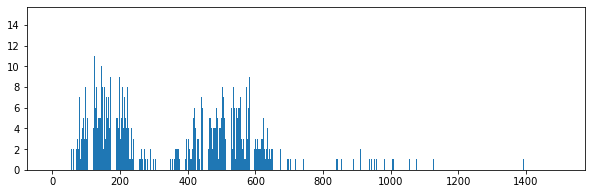

In [258]:
plt.figure(figsize=(10,3))
plt.bar(range(0, 1500), input_bufdpp[0:1500])#, edgecolor='black')
plt.show()

In [256]:
# Convierte el array de NumPy a un DataFrame de Pandas
df = pd.DataFrame(input_bufdpp)

# Guarda el DataFrame como un archivo CSV
df.to_csv('hist_signal_com_03.csv', index=False)

## Fin del archivo

**Autor**: Fabian Andres Castaño